In [59]:
# Active our virtual environment and confirm it worked
! source ./venv/bin/activate
! whereis python

zsh:source:1: no such file or directory: ./venv/bin/activate
python:


In [60]:
# define some helper functions to make our main event loop more readable
import math
import re

def objName(event):
    return event["ObjectDetails"]["Name"]

def parentObjName(event):
    # Use regex to match the base string before any underscores and digits
    match = re.match(r'(.+?)(?:_\d+)?$', event["ObjectDetails"]["Name"])
    if match:
        return match.group(1)
    return event["ObjectDetails"]["Name"]

def objPos(event):
    return event["ObjectDetails"]["Position"]

def stringToTuple(string):
    return tuple(float(x) for x in string[1:-1].split(','))

def moveDistance(start, end):
    return math.dist(stringToTuple(objPos(start)), stringToTuple(objPos(end)))


In [61]:
# define an ActivityPlan class that will allow us to create an activity plan in a stateful way
import json
from string import ascii_uppercase

class ActivityPlan:
    def __init__(self, path):
        self.activities = [] # an array that will store the activities in the plan
        self.counter = 0
        self.currentAdd1 = None # temporarily store a GameObject Added event as we deduce the occurence of slices
        self.currentAdd2 = None # temporarily store a GameObject Added event as we deduce the occurence of slices
        self.currentGrab = None # temporarily store a GameObject Picked Up event as we deduce the occurence of moves
        self.currentRelease = None # temporarily store a GameObject Let Go event as we deduce the occurence of moves
        self.currentFixed = [] # temporarily store all GameObjects that are fixed
        self.currentUnfixed = None # temporarily store all GameObjects that are fixed
        self.loadEvents(path)
        print(len(self.events))
        self.parseEvents()

    def resetMove(self):
        self.currentGrab = None
        self.currentRelease = None
    
    def resetSlice(self):
        self.currentAdd1 = None
        self.currentAdd2 = None

    def loadEvents(self, path):
        self.path = path
        with open(path, 'r') as f:
            self.events = json.load(f)

    
    def parseEvents(self):
        for event in self.events:
            if (event["EventType"] == "Slice Added") : # Added (added due to a slice)
                self.resetMove()
                if (objName(event).endswith("_0")):
                    self.currentAdd1 = event
                if (objName(event).endswith("_1")):
                    self.currentAdd2 = event
                self.attemptSliceActivity()

            if (event["EventType"] == "GameObject Picked Up") : # Picked Up (A game object was grabbed by the user)
                self.resetSlice()
                self.resetMove()
                self.currentGrab = event

            if (event["EventType"] == "GameObject Let Go") : # Let Go (A game object was released by the user)
                self.resetSlice()
                self.currentRelease = event
                self.attemptMoveActivity()
            
            if (event["EventType"] == "Temporary Support Added") : # Let Go (A game object was released by the user)
                newActivity = self.computeSupport(event)
                self.addActivity(newActivity)

            if (event["EventType"] == "GameObject Temporarily Fixed") : # Fixed (removes gravity, simulating temporary bracing)
                self.currentFixed.append(event)

            if (event["EventType"] == "GameObject Unfixed") : # Unfixed (resumes gravity for that object, simulating removal of bracing)
                self.currentUnfixed = event
                self.attemptBracingActivity()



    def attemptMoveActivity(self):
            if (self.currentGrab and objName(self.currentGrab) == objName(self.currentRelease)):
                newActivity  = self.computeMove(self.currentGrab, self.currentRelease)
                self.addActivity(newActivity)

    def attemptSliceActivity(self):
        if (self.currentAdd1 and self.currentAdd2):
            newActivity = self.computeSlice(self.currentAdd1, self.currentAdd2)
            self.addActivity(newActivity)

    def attemptBracingActivity(self):
        for event in self.currentFixed:
            if (objName(event) == objName(self.currentUnfixed)):
                newActivity = self.computeBracing(event, self.currentUnfixed)
                self.addActivity(newActivity)
                self.currentFixed.remove(event)

    def addActivity(self, activity):
        # activity["_id"] = ascii_uppercase[self.counter]
        activity["_id"] = str(self.counter)
        self.activities.append(activity)
        self.counter += 1

    def computeDependencies(self, new):
        dependencies = []
        for previous in self.activities:
            if (new["object"] in previous["dependentObjects"]):
                dependencies.append(previous["_id"])
        if (len(dependencies) == 0):
            dependencies = [None]
        return dependencies


    def computeMove(self, start, end):
        # print(objName(start), "moved from:", objPos(start), "to:", objPos(end))
        activity = {
            "type": "move",
            "object": objName(start),
            "dependentObjects": [objName(start)],
            "startEvent": start,
            "endEvent": end,
            "startPosition": stringToTuple(objPos(start)),
            "endPosition": stringToTuple(objPos(end)),
            "moveDistance": moveDistance(start, end),
        }
        activity["description"] = "Move \"" + objName(start) + "\""
        activity["duration"] = round(activity["moveDistance"], 1)
        activity["dependencies"] = self.computeDependencies(activity)
        return activity

    def computeSlice(self, create1, create2):
        parentObj = parentObjName(create1)
        activity = {
            "type": "slice",
            "object": parentObj,
            "dependentObjects": [objName(create1), objName(create2)],
            "createEvent1": create1,
            "createEvent2": create2
        }
        activity["description"] = "Slice \"" + parentObj + "\""
        activity["duration"] = 2
        activity["dependencies"] = self.computeDependencies(activity)
        return activity
    
    def computeBracing(self, fixed, unfixed):
        activity = {
            "type": "bracing",
            "object": objName(fixed),
            "dependentObjects": [objName(fixed)],
            "startEvent": fixed,
            "endEvent": unfixed,
        }
        activity["description"] = "Brace \"" + objName(fixed) + "\""
        activity["duration"] = 2
        activity["dependencies"] = self.computeDependencies(activity)
        return activity
    
    def computeSupport(self, event):
        activity = {
            "type": "support",
            "dependentObjects": [],
            "startEvent": event,
        }
        activity["description"] = "Create a temporary support"
        activity["duration"] = 2
        activity["dependencies"] = [None]
        return activity

361
Activity	 Duration	 Dependencies		 Description	
0 		 20.2 		 [None] 			 Move "Brace1_4UPN"
1 		 19.0 		 [None] 			 Move "Brace1_1UPN"
2 		 18.3 		 [None] 			 Move "Frame1 Plate4"
3 		 16.1 		 [None] 			 Move "Frame1 Plate1"
4 		 2 		 [None] 			 Create a temporary support
5 		 16.9 		 [None] 			 Move "Frame1 Connection Under"
6 		 20.5 		 [None] 			 Move "Brace1_2UPN"
7 		 19.4 		 [None] 			 Move "Brace1_3UPN"
8 		 17.1 		 [None] 			 Move "Frame1 Connection over"
9 		 5.1 		 [None] 			 Move "MainBeam1_HEA"
10 		 2 		 ['9'] 			 Slice "MainBeam1_HEA"
11 		 17.6 		 ['10'] 			 Move "MainBeam1_HEA_0"
12 		 14.4 		 ['10'] 			 Move "MainBeam1_HEA_1"
13 		 0.2 		 ['10', '12'] 			 Move "MainBeam1_HEA_1"
14 		 2 		 [None] 			 Create a temporary support
15 		 16.4 		 [None] 			 Move "Frame1Plate3"
16 		 2 		 [None] 			 Slice "pipe1"
17 		 19.5 		 ['16'] 			 Move "pipe1_1"
18 		 2 		 [None] 			 Create a temporary support
19 		 18.5 		 [None] 			 Move "Frame1Plate2"
20 		 2 		 ['16'] 			 Slice "

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cheche_pm/cheche_pm.py:849: UserWarning: !WARNING: Creating Project data dictionary...
  warnings.warn("!WARNING: Creating Project data dictionary...")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cheche_pm/cheche_pm.py:771: UserWarning: !WARNING: Creating dummy variables and creating the project network...
  warnings.warn("!WARNING: Creating dummy variables and creating the project network...")


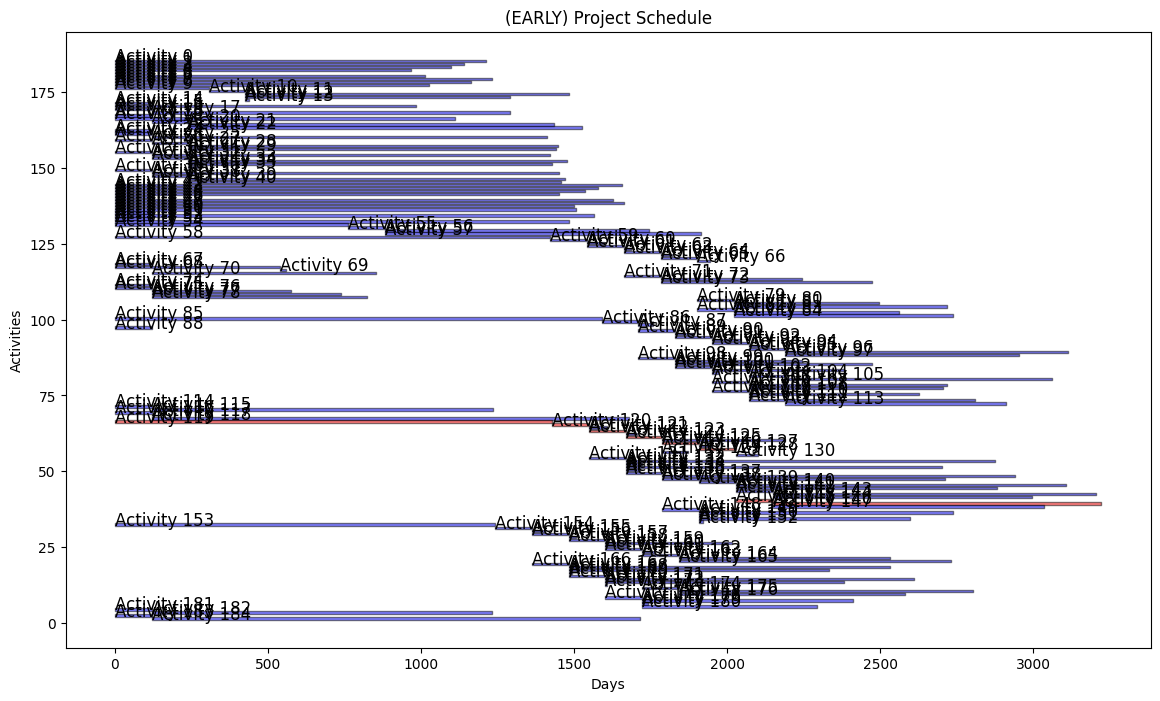

In [62]:
import time

start = time.time()

# create and analyze the activity plan using our ActivityPlan class
myPlan = ActivityPlan('./LogFile 4.json')

# cheche_pm allows us to create a critical path schedule diagram from our ActivityPlan class
from cheche_pm import Project
p = Project()

print ("Activity\t", "Duration\t", "Dependencies\t\t", "Description\t")
for activity in myPlan.activities:
    p.add_activity(activity_name=activity["_id"], activity_duration = 60 * activity["duration"], activity_precedence=activity["dependencies"], a_desc=activity["description"], activity_resources=[0])
    print(activity["_id"], "\t\t", activity["duration"], "\t\t", activity["dependencies"], "\t\t\t", activity["description"])

try:
    p.CPM()
    print("--- %s seconds ---" % (time.time() - start))
    print(p.get_critical_path())
    p.plot_gantt_cpm(save=True)
except:
    pass